## Q1.Graph

- **Les Miserables:** coappearance network of characters in the novel Les Miserables.

In [1]:
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import copy

print(nx.__version__)

3.2.1


In [2]:
competition_net = nx.read_gml("football/football.gml")
competition_net = nx.Graph(competition_net)

print(type(competition_net).__name__)

Graph


## Q2.Hypotheses

- **Hypothesis 1**

    在这个网络中，度数越大的节点说明有更多的大学愿意与它一起比赛，这可能是因为这个学校橄榄球队的实力强劲，受欢迎程度高，多数学校希望挑战它。因此，我们提出假设：那些实力强劲的学校之间更愿意两两相互比赛，从而提高实力，而实力较弱的学校也倾向于与和自己水平相近的学校比赛，以避免被碾压。

- **Hypothesis 2**

    我的第二个假设是那些实力强的学校之间存在着一个联盟，他们彼此之间联系紧密，相互聚集在一起，并且与低水平球队之间来往频率低。

- **Hypothesis 1 Addition**

    对假设1进行补充，两个球队之间是否进行比赛，更有可能的是学校本身的一些属性，即在相同协会之间的学校之间由于形成了协会这一较为紧密的群体，相比于实力水平是否接近，同一协会之间的学校更有可能相互交流学习，进行比赛。所以，提出假设：同一协会的学校之间倾向于相互比赛。


## Q3.Measures

- **Hypothesis 1**

    使用同配性对假设进行检验，同配性用作考察度值相近的顶点是否倾向于互相连接。如果总体上度大的顶点倾向于连接度大的顶点，那么就称网络的度正相关的，或者称网络是同配的；如果总体上度大的顶点倾向于连接度小的顶点，那么就称网络的度负相关的，或者成称络是异配的。使用Networkx的degree_assortativity_coefficient方法可以计算度同配性系数。
    r>0表示整个网络呈同配性结构，度大的节点倾向于和毒打的节点相连；r<0表示整个网络呈现易配性；r=0表示网络结构不存在相关性。

- **Hypothesis 2**

    使用富人俱乐部系数对假设进行检验，富人俱乐部指的是网络中度值高的节点之间的连接，往往表示出比度值低的节点之间的连接更加紧密的趋势，这些高度值的节点在全局交流中具有重要的作用。

- **Hypothesis 1 Addition**

    同配概念的一般化，同配就是指属性相近的节点倾向于互相连接，这里的属性可以是度也可以是其他特性。这里我使用节点的value属性，即每所大学所属的协会，同样使用同配性对假设进行检验，通过Networkx的attribute_assortativity_coefficient方法计算属性同配系数。


## Q4.Result and Analysis

In [3]:
real_assortativity = nx.degree_assortativity_coefficient(competition_net)
print(f"Real Assortativity Coefficient is {real_assortativity}")

real_rich_club = nx.rich_club_coefficient(competition_net,normalized=False, seed=2024)[10]
print(f"Real Rich Club Coefficient is {real_rich_club}")

Real Assortativity Coefficient is 0.16244224957444287
Real Rich Club Coefficient is 0.10656010656010656


analysis

In [4]:
competition_degree_sequence = list(dict(nx.degree(competition_net)).values())

# We need to generate enough null graphs to make a reasonable assessment of the null distribution
model_assortativity = []
model_rich_club = []
for i in range(1000):
    # Use the configuration model to create a null graph
    null_graph = nx.configuration_model(competition_degree_sequence)
    null_graph = nx.Graph(null_graph) # removes parallel edges
    null_graph.remove_edges_from(nx.selfloop_edges(null_graph)) # removes self-loops
    model_assortativity.append(nx.degree_assortativity_coefficient(null_graph))
    try:
        model_rich_club.append(nx.rich_club_coefficient(null_graph, normalized=False, seed=2024)[11])
    except KeyError as e:
        model_rich_club.append(0)

In [5]:
zscores_1 = stats.zscore([real_assortativity] + model_assortativity)
zscores_2 = stats.zscore([real_rich_club] + model_rich_club)

print(f"zscores of assortativity is {zscores_1[0]}\nzscores of rich_club is {zscores_2[0]}")

zscores of assortativity is 3.686363366133918
zscores of rich_club is -0.2222949437692691


analysis

analysis

**Addition**

In [6]:
real_attr_assortativity = nx.attribute_assortativity_coefficient(competition_net, "value")

print(real_attr_assortativity)

0.6079383668260255


analysis

In [7]:
def my_null_model(graph:nx.Graph):
    # 基于断边重连的1阶度分布零模型
    random_graph = copy.deepcopy(graph)
    for _ in range(graph.number_of_edges()*2):
        nx.double_edge_swap(random_graph) # 随机交换两条边的连接，并且不改变节点的度数
    return random_graph

In [8]:
model_attr_assortativity = []
for j in range(1000):
    null_graph = my_null_model(competition_net)
    model_attr_assortativity.append(nx.attribute_assortativity_coefficient(null_graph, "value"))
    print(f"\r {j+1} / 1000", end='\r')

In [9]:
# Prepend the real assortativity to the model list and have scipy calculate the zscores
zscores_3 = stats.zscore([real_attr_assortativity] + model_attr_assortativity)

# Just print out the first score which corresponds to the real network
print(zscores_3[0])

27.262678096693104


**Illustration**

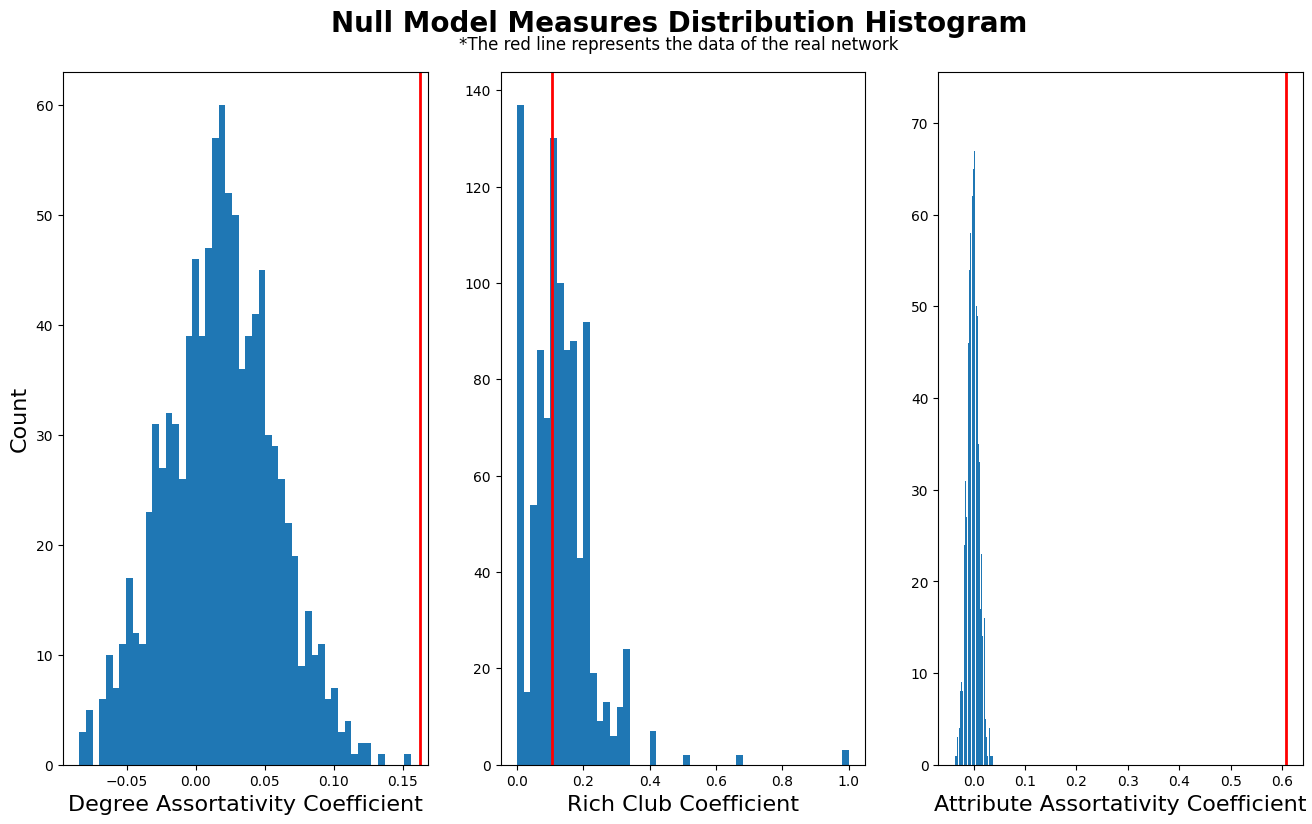

In [17]:
plt.figure(figsize=(16, 9))

plt.subplot(131)
plt.hist(model_assortativity, bins=50)
plt.axvline(real_assortativity, lw=2, color="red")
plt.xlabel("Degree Assortativity Coefficient", fontsize=16)
plt.ylabel("Count", fontsize=16)

plt.subplot(132)
plt.hist(model_rich_club, bins=50)
plt.axvline(real_rich_club, lw=2, color="red")
plt.xlabel("Rich Club Coefficient", fontsize=16)

plt.subplot(133)
plt.hist(model_attr_assortativity, bins=50)
plt.axvline(real_attr_assortativity, lw=2, color="red")
plt.xlabel("Attribute Assortativity Coefficient", fontsize=16)


plt.text(-1.25, 80, "Null Model Measures Distribution Histogram", fontsize=20, fontweight="bold")
plt.text(-1.0, 78, "*The red line represents the data of the real network", fontsize=12)
plt.show()

## Q5.Realization